In [1]:
%matplotlib inline

import geocoder
import pandas as pd
import geopandas as gpd

from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [43]:
path = "/home/maita/Documents/Work/Incubator Apply/Data/VZ/"

fatalities = gpd.read_file(path + "fatality_all_monthly_shapefile/fatality_all_monthly.shp")

injuries = gpd.read_file(path + "injury_all_monthly_shapefile/injury_all_monthly.shp")

precincts = gpd.read_file(path+'summary_police_precincts_shapefile/summary_police_precincts.shp')

summary_borough = gpd.read_file(path+'summary_borough_boundaries_shapefile/summary_borough_boundaries.shp')

sections = gpd.read_file(path+'newyork2015/NewYork_Sections.shp')

In [125]:
collisions = gpd.read_file(path+'NYPD_Motor_Vehicle_Collisions.csv')

DriverError: unsupported driver: 'CSV'

In [326]:
chunksize = 10 ** 6 

counts=[chunk['Issuer Precinct'].value_counts() for chunk in pd.read_csv(path+
                                                                         'Parking_Violations_Issued_-_Fiscal_Year_2017.csv', 
                                                                         chunksize=chunksize,
                     parse_dates=['Issue Date'],
                     usecols=['Summons Number','Plate ID','Issuer Precinct','Issuer Code','Issue Date','Sub Division']
                     )]

In [327]:
counts2016=[chunk['Issuer Precinct'].value_counts() for chunk in pd.read_csv(path+
                                                                         'Parking_Violations_Issued_-_Fiscal_Year_2016.csv', 
                                                                         chunksize=chunksize,
                     parse_dates=['Issue Date'],
                     usecols=['Summons Number','Plate ID','Issuer Precinct','Issuer Code','Issue Date','Sub Division']
                     )]

In [334]:
# get the sum of parking violations in each precinct in each year

s2016 = sum(counts2016)
vio_by_precinct_2016 = pd.DataFrame({'Precinct':s2016.index, 'Violation_sum':s2016.values})

s = sum(counts)
vio_by_precinct_2017 = pd.DataFrame({'Precinct':s.index, 'Violation_sum':s.values})

In [342]:
# get the change in parking violations in each precinct from 2016 to 2017...

vio_diff = vio_by_precinct_2017-vio_by_precinct_2016
vio_combined = vio_by_precinct_2017.merge(vio_by_precinct_2016, on='Precinct',suffixes=['_2017','_2016'])
vio_combined['Violation_diff']=vio_combined['Violation_sum_2017']-vio_combined['Violation_sum_2016']

In [343]:
# and join it back onto the geographies
precinctsViol=precincts.merge(vio_combined, on=['Precinct'])

Index(['Precinct', 'Shape_Leng', 'Total_Pop', 'Ages_Under', 'Ages_5_to_',
       'Ages_10_to', 'Ages_15_to', 'Ages_20_to', 'Ages_25_to', 'Ages_45_to',
       'Ages_65_an', 'Ages_18_an', 'SUM_ASZ', 'SUM_VZ_Pri', 'SUM_VZ_P_1',
       'SUM_VZ_P_2', 'SUM_NeighS', 'SUM_Injuri', 'SUM_PedInj', 'SUM_BikeIn',
       'SUM_MVOInj', 'SUM_Fatali', 'SUM_PedFat', 'SUM_BikeFa', 'SUM_MVOFat',
       'SUM_LPI', 'SUM_SIPInt', 'SUM_SIPCor', 'SUM_SpeedH', 'SUM_Signal',
       'SUM_Left_T', 'SUM_VZ_Bik', 'SUM_Enhanc', 'Shape_Le_1', 'Shape_Area',
       'geometry'],
      dtype='object')


In [412]:
# Get the injuries in each precinct
precinctsInj = gpd.sjoin(precincts,injuries, op='contains')

In [413]:
# Figure out how many there were in each precinct, and how the number changed
g=precinctsInj.groupby(['Precinct','YR'])
injSums = g.Injuries.sum().unstack(level=0).transpose()
delta_injuries=pd.DataFrame(injSums['2017']-injSums['2016'],columns=['Injuries_delta'])
delta_injuries['Precinct']=delta_injuries.index

In [414]:
# get one geo-DF with difference in violations cited and in injuries, see how these correlate across districts
precinctsViolInj=precinctsViol.merge(delta_injuries, on='Precinct')

print(precinctsViolInj.corr()[['Violation_diff','Injuries_delta']].loc[['Violation_diff','Injuries_delta']])
calculate_pvalues(precinctsViolInj)[['Violation_diff','Injuries_delta']].loc[['Violation_diff','Injuries_delta']]

                Violation_diff  Injuries_delta
Violation_diff        1.000000       -0.135888
Injuries_delta       -0.135888        1.000000


,Violation_diff,Injuries_delta
Violation_diff,0,0.2386
Injuries_delta,0.2386,0


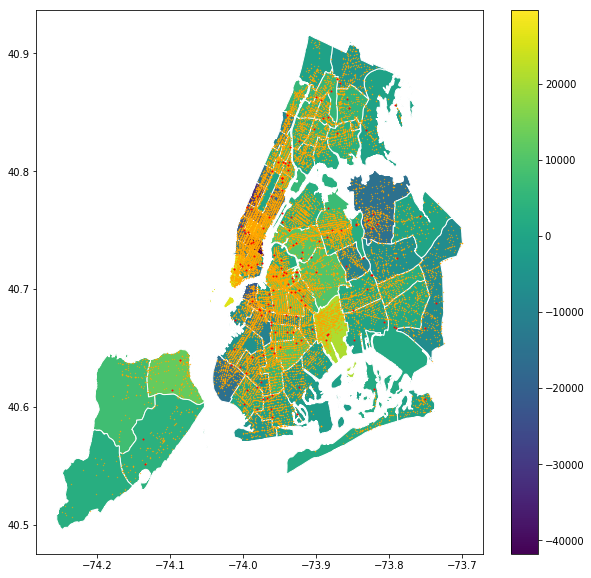

In [397]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

precinctsViol.plot(ax=ax, column='Violation_diff', edgecolor='white',legend=True)

#sections.plot(ax=ax)
injuries[injuries.BikeInjuri==1].plot(ax=ax, marker='o', color='orange',markersize=0.1)
fatalities[fatalities.BikeFatali==1].plot(ax=ax, marker='o', color='red', markersize=1)

In [419]:
# see if the overall sum of injuries/fatalities is somehow related to the difference in parking violations
calculate_pvalues(precinctsViol[['Violation_diff']+[k for k in precinctsViol.keys() if 'SUM' in k and ('In' in k or 'Fa' in k)]])

,Violation_diff,SUM_Injuri,SUM_PedInj,SUM_BikeIn,SUM_MVOInj,SUM_Fatali,SUM_PedFat,SUM_BikeFa,SUM_MVOFat,SUM_SIPInt
Violation_diff,0,0.1203,0.6676,0.5521,0.0975,0.6032,0.5293,0.2094,0.1268,0.6938
SUM_Injuri,0.1203,0,0,0.3344,0,0,0.0001,0.7734,0.0008,0.1116
SUM_PedInj,0.6676,0,0,0.0011,0,0.0059,0.0146,0.6627,0.0477,0.0015
SUM_BikeIn,0.5521,0.3344,0.0011,0,0.6046,0.7426,0.3013,0.5873,0.2411,0.0001
SUM_MVOInj,0.0975,0,0,0.6046,0,0,0.0001,0.783,0.0004,0.4885
SUM_Fatali,0.6032,0,0.0059,0.7426,0,0,0,0.0511,0,0.0814
SUM_PedFat,0.5293,0.0001,0.0146,0.3013,0.0001,0,0,0.6259,0.1169,0.0893
SUM_BikeFa,0.2094,0.7734,0.6627,0.5873,0.783,0.0511,0.6259,0,0.6231,0.1598
SUM_MVOFat,0.1268,0.0008,0.0477,0.2411,0.0004,0,0.1169,0.6231,0,0.7518
SUM_SIPInt,0.6938,0.1116,0.0015,0.0001,0.4885,0.0814,0.0893,0.1598,0.7518,0


In [116]:
section_with_precinct = gpd.sjoin(sections[~sections.geometry.isna()],precincts[['Precinct','geometry']],
                                  op='intersects')

In [136]:
around_sections=section_with_precinct.buffer(0.0001)

In [148]:
section_with_buffer = section_with_precinct.copy()
section_with_buffer['geometry']=around_sections

In [215]:
inj_on_road = gpd.sjoin(injuries[~injuries.geometry.isna()],section_with_buffer[[
    k for k in section_with_buffer.columns if not 'index' in k]],op='intersects')

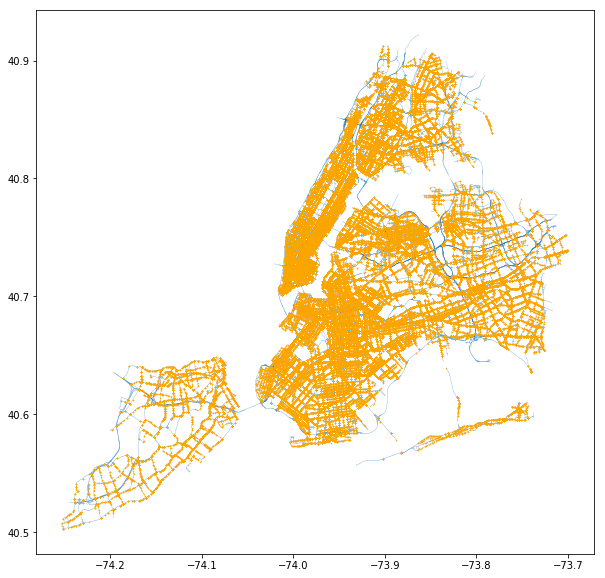

In [156]:
fig2, ax2 = plt.subplots(figsize=(10,10))

#section_with_precinct.plot(ax=ax2, column='iri',legend=True)
around_sections.plot(ax=ax2)
inj_on_road.plot(ax=ax2,color='orange',markersize=0.1)

In [219]:
g=inj_on_road.groupby(['index_right'])

In [220]:
inj_sect_pivot = g['Injuries'].sum()
inj_sect_pivot = pd.DataFrame({'sect_buffer_id':inj_sect_pivot.index, 'Injuries':inj_sect_pivot.values})

In [260]:
# we got some duplicates from the precinct join earlier...
corresponding_buffer['buffer_index']=corresponding_buffer.index
corresponding_buffer = corresponding_buffer.drop_duplicates(subset='buffer_index')
#corresponding_buffer = corresponding_buffer.drop('index_right')

/home/maita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [266]:
corresponding_buffer = corresponding_buffer.loc[inj_sect_pivot.sect_buffer_id.values]
corresponding_buffer.index = corresponding_buffer.buffer_index
#[k for k in section_with_buffer.keys() if 'index' in k]

In [269]:
sections.keys()

Index(['year_recor', 'state_code', 'route_id', 'begin_poin', 'end_point',
       'aadt', 'aadt_conbi', 'aadt_singl', 'access_con', 'at_grade_o',
       'base_thick', 'base_type', 'counter_pe', 'county_cod', 'cracking_p',
       'curves_a', 'curves_b', 'curves_c', 'curves_d', 'curves_e', 'curves_f',
       'dir_factor', 'f_system', 'facility_t', 'faulting', 'future_aad',
       'future_a_1', 'future_fac', 'future_f_1', 'grades_a', 'grades_b',
       'grades_c', 'grades_d', 'grades_e', 'grades_f', 'hov_lanes', 'hov_type',
       'iri', 'iri_year', 'k_factor', 'lane_width', 'last_overl', 'median_typ',
       'median_wid', 'nhs', 'nhs_year', 'number_sig', 'ownership',
       'pct_green_', 'pct_pass_s', 'pct_peak_c', 'pct_peak_s', 'peak_capac',
       'peak_lanes', 'peak_parki', 'psr', 'route_numb', 'route_nu_1',
       'route_qual', 'route_sign', 'rutting', 'shoulder_t', 'shoulder_w',
       'shoulder_1', 'signal_typ', 'speed_limi', 'stop_signs', 'strahnet',
       'structure_', 'surface_t

In [270]:
# possible variables of interest
inj_sect_pivot['iri'] = corresponding_buffer.iri.values
inj_sect_pivot['lane_width']=corresponding_buffer.lane_width.values
inj_sect_pivot['truck']=corresponding_buffer.truck.values # 1 or two: designated truck network. 0: nothing
inj_sect_pivot['length']=corresponding_buffer.Shape_Leng_left
inj_sect_pivot['aadt']=corresponding_buffer.aadt
inj_sect_pivot['parking']=corresponding_buffer.peak_parki #1 = 1 side, 2 = 2 sides, 3= no parking

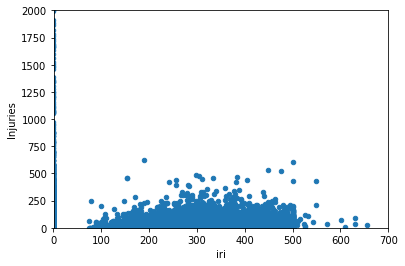

In [292]:

inj_sect_pivot.plot(x='iri',y='Injuries', kind='scatter', xlim=[1,700], ylim=[0,2000])

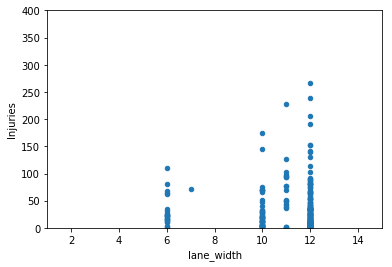

In [294]:
inj_sect_pivot.plot(x='lane_width',y='Injuries', kind='scatter', xlim=[1,15], ylim=[0,400])

In [325]:
truck_cat = inj_sect_pivot.truck.value_counts()
inj_by_truck_cat = [inj_sect_pivot.Injuries[inj_sect_pivot.truck==i].sum() 
                    for i in inj_sect_pivot.truck.value_counts().index]

inj_sect_pivot.plot(x='truck',y='Injuries', kind='scatter', xlim=[0,3], ylim=[0,100])

ValueError: values cannot be used without an aggfunc.

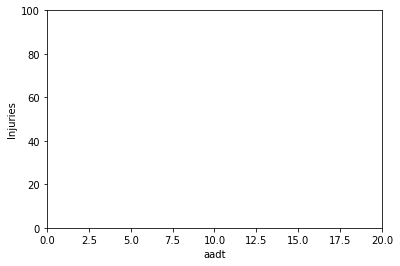

In [303]:
inj_sect_pivot.plot(x='aadt',y='Injuries', kind='scatter', xlim=[0,20], ylim=[0,100])#most of them not measured

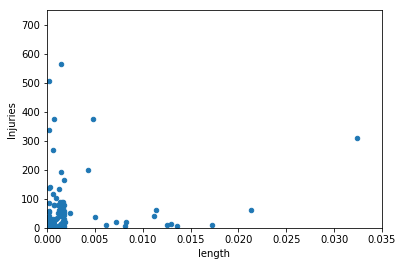

In [314]:
inj_sect_pivot.plot(x='length',y='Injuries', kind='scatter', xlim=[0,0.035], ylim=[0,750])